In [1]:
import gpjax 
from gpjax import SparseDataset, Prior
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

key = jr.PRNGKey(123)

In [2]:
X = jnp.sort(jr.uniform(key, shape=(2000, 1)), axis=0)
f = lambda x: jnp.sin(15*x) * jnp.cos(7*x)
latent = f(X)
y = latent + jr.normal(key, shape=latent.shape)*0.05

In [3]:
m = 50
z_idx = jr.choice(key, jnp.arange(X.shape[0]), replace=False, shape=(m, ))
Z = X[z_idx, :]

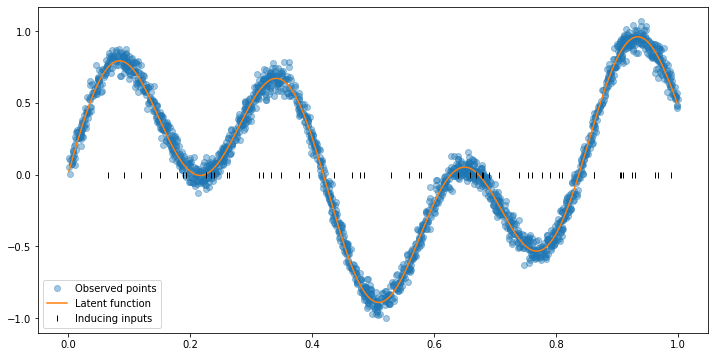

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X, y, 'o', alpha=0.4, label='Observed points')
ax.plot(X, latent, label='Latent function')
ax.plot(Z, jnp.zeros_like(Z), '|', color='black', label='Inducing inputs')
ax.legend(loc='best')

In [5]:
training = SparseDataset(X = X, y=y, Z=Z)
print(training)

- Number of datapoints: 2000
- Dimension: 1
- Number of inducing points: 50


In [6]:
prior = Prior(kernel = gpjax.kernels.RBF())
lik = gpjax.likelihoods.Gaussian()
posterior = prior * lik

Unlike approaches such as the FITC approximation, the VFE approach being considered here maintains an exact generative model. Scalability is induced through the use of 
approximate inference over the model's ELBO term. For that reason, to ensure a faithful representation of the underlying maths is maintained, we'll be using the above posterior distribution in subsequent steps.

In [7]:
from gpjax.parameters import initialise, build_all_transforms
base_params = initialise(posterior)

As is standard practice for fitting of the VFE approximation, we'll also learn an _optimal_ set of inducing locations. To ensure that these become part of our gradient based optimisation later, we'll include them in our parameter set. We can add thhem in using the `add_parameter` function. 

In [8]:
params = gpjax.utils.add_parameter(base_params, ('inducing_inputs', Z))

In [9]:
from gpjax.config import get_defaults

configs = get_defaults()
constrainer, unconstrainer = build_all_transforms(params.keys(), configs)

In [10]:
params_tr = unconstrainer(params)

In [11]:
from gpjax.utils import woodbury_matrix_identity
from gpjax.kernels import gram, cross_covariance

Kff = gram(prior.kernel, X, params)
Kuu = gram(prior.kernel, Z, params)
Kuf = cross_covariance(prior.kernel, X, Z, params)
Kfu = cross_covariance(prior.kernel, Z, X, params)

In [12]:
A = jnp.diag(jnp.diag(Kff))

In [13]:
woodbury_matrix_identity(A, Kfu, Kuf, Kuu, y)

DeviceArray(694.09588799, dtype=float64)

In [14]:
from gpjax.objectives import elbo

SyntaxError: invalid syntax (approximate.py, line 39)

In [ ]:
elbo_obj = elbo(posterior, constrainer, to_minimise=True)

In [ ]:
elbo_obj(params_tr, training)